# Bike Sharing 

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statistics

from datetime import datetime
from collections import Counter
from scipy import stats as sp

%matplotlib inline

### Import data

In [110]:
station_df = pd.read_csv('data/station.csv')
trip_df = pd.read_csv('data/trip.csv')
weather_df = pd.read_csv('data/weather.csv')

### Process Data


In [111]:
#Convert to datetime so that it can be manipulated more easily
trip_df.start_date = pd.to_datetime(trip_df.start_date, format='%m/%d/%Y %H:%M')
trip_df.end_date = pd.to_datetime(trip_df.end_date, format='%m/%d/%Y %H:%M')

#duration is time of trip in seconds; convert to minutes
trip_df.duration = trip_df.duration / 60
trip_df.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

### Examine station data

In [112]:
station_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [113]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int64
name                 70 non-null object
lat                  70 non-null float64
long                 70 non-null float64
dock_count           70 non-null int64
city                 70 non-null object
installation_date    70 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 3.9+ KB


In [114]:
#look for missing data; should be zero as info summary above gives 70 entries for each column
station_df.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

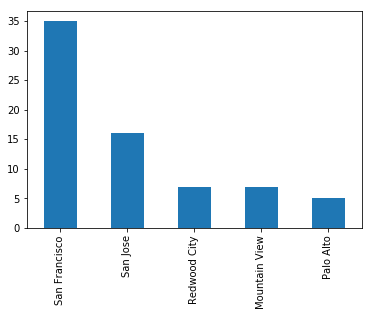

In [115]:
#stations by city
station_df.city.value_counts().plot(kind='bar')
# SF has 35 stations

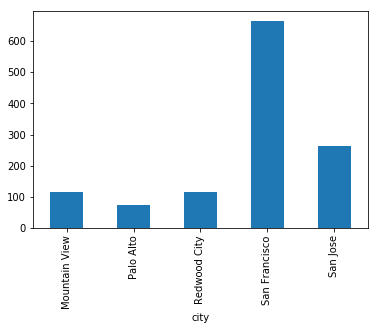

In [116]:
# number of docks per city   
station_df.groupby('city')['dock_count'].sum().plot(kind='bar')
# SF has 665

### Narrow focus to SF

In [117]:
# Narrow focus to SF stations
sf_stations = station_df.loc[station_df.city == 'San Francisco']
sf_stations.head()

,id,name,lat,long,dock_count,city,installation_date
32,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,8/19/2013
33,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,8/19/2013
34,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,8/19/2013
35,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,8/19/2013
36,47,Post at Kearney,37.788975,-122.403452,19,San Francisco,8/19/2013


In [118]:
# Narrow focus to SF trips
sf_id = list(sf_stations.id)
sf_trips = trip_df[trip_df.start_station_id.isin(sf_id)]
sf_trips.start_station_id.unique()

array([66, 59, 49, 64, 41, 47, 67, 74, 39, 58, 56, 55, 61, 72, 45, 76, 62,
       46, 68, 71, 69, 73, 48, 75, 70, 50, 77, 65, 60, 42, 54, 57, 51, 63,
       82])

### Examine SF trip data

In [119]:
sf_trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103
5,4927,1.716667,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109
8,4760,1.883333,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103
10,4549,2.083333,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109


In [120]:
sf_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603708 entries, 0 to 669958
Data columns (total 11 columns):
id                    603708 non-null int64
duration              603708 non-null float64
start_date            603708 non-null datetime64[ns]
start_station_name    603708 non-null object
start_station_id      603708 non-null int64
end_date              603708 non-null datetime64[ns]
end_station_name      603708 non-null object
end_station_id        603708 non-null int64
bike_id               603708 non-null int64
subscription_type     603708 non-null object
zip_code              597599 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 55.3+ MB


In [121]:
# Create column denoting weekend or weekday: DOW

sf_trips['weekday'] = pd.DatetimeIndex(sf_trips.start_date).dayofweek

sf_trips['DOW'] = None
sf_trips['DOW'] = ['weekend' if day in [5,6] else "weekday" for day in sf_trips['weekday']]
sf_trips = sf_trips.copy()

/Users/janellaslaga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/janellaslaga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/janellaslaga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [122]:
sf_trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,weekday,DOW
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,3,weekday
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,3,weekday
5,4927,1.716667,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109,3,weekday
8,4760,1.883333,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,3,weekday
10,4549,2.083333,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109,3,weekday


In [123]:
sf_trips.duration.describe()         

count    603708.000000
mean         17.117811
std         380.557814
min           1.000000
25%           5.916667
50%           8.750000
75%          12.600000
max      287840.000000
Name: duration, dtype: float64

The mean duration of 17.117811 is greater than the 75% of the data, and the std is 380.557814 (over 6 hours). The max duration is 4797 hours. Clearly, outliers are strongly affecting the data. Rather than replacing the values with the median value for duration, these trips will not included in the clean dataset as these trips are most likely errors in usage.

#### Remove Outliers

Since the std is so large and the 3Q is 12.6, using 3SD to remove outliers will not be effective. Instead, we used quantiles to identify extreme values.

In [124]:
# quartile_1, quartile_3 = np.percentile(sf_trips['duration'], [25, 75])
# iqr = quartile_3 - quartile_1
# lower_bound = quartile_1 - (float(iqr) * 1.5)
# upper_bound = quartile_3 + (float(iqr) * 1.5)

# sf_trips_clean2 = sf_trips.loc[sf_trips.duration < upper_bound]

## This results in a lower bound is a negative number (negative ride duration) and an upper bound of 22.6249995.
## This removes a significant amount of valid trips from the data. The method below retains 98% of the data and
## retaining trips with a resonable range of durations for us to explore.

In [125]:
# large std of 380.557814 and 3Q = 12.6; use quantiles instead of 3SD

np.quantile(sf_trips.duration, .98)  #102.64766666666645

102.64766666666645

In [126]:
sf_trips_clean = sf_trips.loc[sf_trips.duration < np.quantile(sf_trips.duration, 0.98)]

#### Compare before and after removal of outliers: sf_trips vs sf_trips_clean

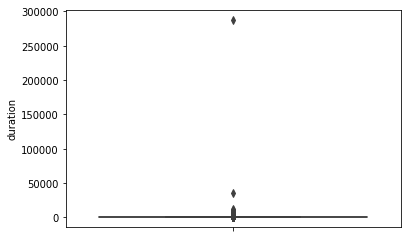

In [127]:
sb.boxplot(sf_trips['duration'], orient='v')

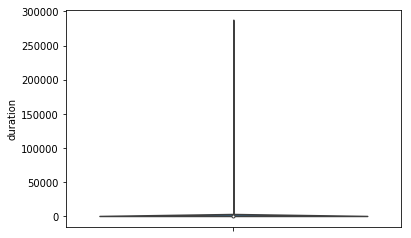

In [128]:
sb.violinplot(sf_trips['duration'], orient='v', showfliers=False)

In [129]:
sf_trips.duration.describe()  #with outliers

count    603708.000000
mean         17.117811
std         380.557814
min           1.000000
25%           5.916667
50%           8.750000
75%          12.600000
max      287840.000000
Name: duration, dtype: float64

In [130]:
sf_trips_clean.duration.describe() #without outliers

count    591633.000000
mean         10.652207
std           9.414143
min           1.000000
25%           5.866667
50%           8.616667
75%          12.300000
max         102.633333
Name: duration, dtype: float64

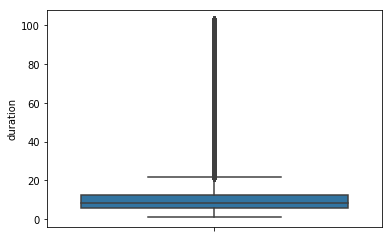

In [131]:
sb.boxplot(sf_trips_clean['duration'], orient='v')

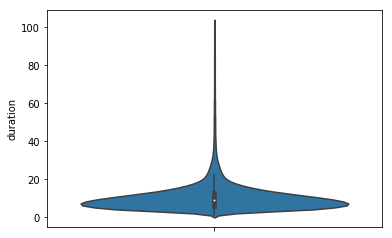

In [132]:
sb.violinplot(sf_trips_clean['duration'], orient='v', showfliers=False)

In [133]:
sf_trips_clean.duration.describe()

count    591633.000000
mean         10.652207
std           9.414143
min           1.000000
25%           5.866667
50%           8.616667
75%          12.300000
max         102.633333
Name: duration, dtype: float64

The mean is now 10.652207 and the std is 9.414143. After the removal of the outliers, we can see from the violin plot the density of the data around the mean.

#### Comparisons: Subscriber vs. Customer, Weekday vs. Weekend

We divide data by subscription type and by day of week to examine possible differences in ride usage. These categories may provide insight into patterns of commuters or causual rides.

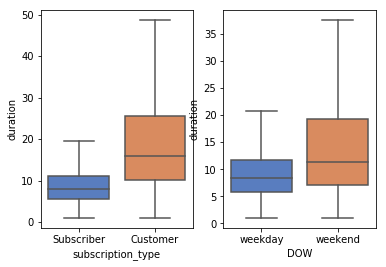

In [134]:
plt.subplot(1, 2, 1)
sb.boxplot(x='subscription_type', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

plt.subplot(1, 2, 2)
sb.boxplot(x='DOW', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

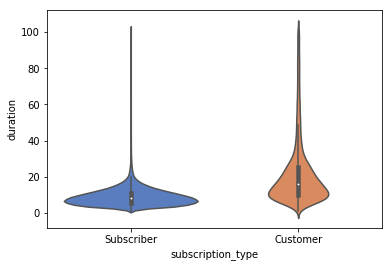

In [135]:
sb.violinplot(x='subscription_type', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

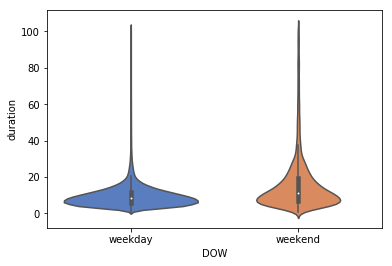

In [136]:
sb.violinplot(x='DOW', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

Most subscriber trips have a duration less than 20 minutes while the customer trips have a larger range and tend to a longer duration. Similar patterns can be seen in comparing the weekday versus weekend durations. It may be that weekday trips tend to be commuters (and thus subscribers) whereas weekend trips (and one off customers) would be sightseeing and more leisurely rides.

In [137]:
# Compare counts of trips per hour weekday vs weekend
# As most trips are weekday trips, we examine proportional numbers

In [138]:
weekday_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.DOW == 'weekday'].start_date).hour
weekend_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.DOW == 'weekend'].start_date).hour

In [139]:
weekday_counts = Counter(weekday_counts)
weekend_counts = Counter(weekend_counts)

In [140]:
weekday_props = {hour:weekday_counts[hour]/sum(weekday_counts.values()) for hour in weekday_counts}
weekend_props = {hour:weekend_counts[hour]/sum(weekend_counts.values()) for hour in weekend_counts}

In [141]:
xd = range(0,24)
yd = [weekday_props[hour] for hour in range(0,24)]

xe = range(0,24)
ye = [weekend_props[hour] for hour in range(0,24)]

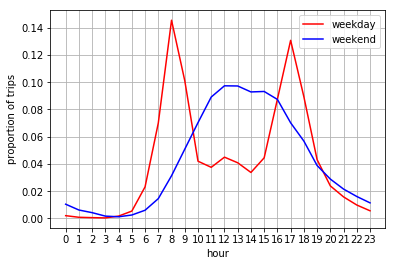

In [142]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(xd, yd, 'r-', xe, ye, 'b-')
plt.xticks(xe)

ax.set_xlabel('hour')
ax.set_ylabel('proportion of trips') #at start time
ax.legend(['weekday', 'weekend'])
ax.grid()


The clear spikes at morning and evening commute times and a lesser spike at lunchtime support our observations that weekday usuage is tied to commuting. Weekend usage, on the otherhand, has a gentle curve peaking midday and gradually decreasing through the afternoon as one would expect from more leisurely rides and sightseeing.

### How does weather affect bike usage?

Does weather have a strong effect on bike usage? We examine how temperature and precipitation affect bike usage, specifically duration of trips.

In [143]:
weather_df.head()


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [144]:
weather_df.shape

(3665, 24)

In [145]:
weather_df['precipitation_inches'].unique()  
#there is a 'T'; not all values are numberic

array(['0', '0.23', 'T', '0.01', '0.28', '0.63', '0.29', '0.06', '0.85',
       '0.09', '0.64', '0.42', '0.35', '0.43', '0.22', '0.74', '0.03',
       '0.12', '0.16', '0.49', '0.17', '0.08', '0.04', '0.53', '0.07',
       '0.02', '0.83', '1.06', '1.71', '0.37', '0.27', '0.45', '0.78',
       '0.88', '0.66', '0.47', '0.1', '0.61', '0.14', '0.05', '0.68',
       '0.97', '0.26', '0.15', '0.87', '0.57', '0.69', '0.32', '0.21',
       '0.24', '0.52', '0.36', '0.33', '0.25', '0.11', '0.2', '1.18',
       '1.43', '3.12', '0.48', '0.19', '1.09', '0.65', '0.13', '0.91',
       '0.99', '0.18', '0.4', '1.07', nan, '0.41', '0.34', '1.25', '1.85',
       '3.36', '0.71', '1.3', '0.72', '0.6', '0.51', '1.2', '1.28',
       '3.23', '0.55', '1.26', '0.39'], dtype=object)

In [146]:
# Replace non numeric with mean values

In [147]:
weather_df.precipitation_inches = np.where(weather_df.precipitation_inches == 'T', np.nan, weather_df.precipitation_inches)
weather_df.precipitation_inches = weather_df.precipitation_inches.astype(float)
weather_df.precipitation_inches = weather_df.precipitation_inches.fillna(np.nanmean(weather_df.precipitation_inches))

In [148]:
weather_df['precipitation_inches'].unique()  

array([0.        , 0.23      , 0.02094291, 0.01      , 0.28      ,
       0.63      , 0.29      , 0.06      , 0.85      , 0.09      ,
       0.64      , 0.42      , 0.35      , 0.43      , 0.22      ,
       0.74      , 0.03      , 0.12      , 0.16      , 0.49      ,
       0.17      , 0.08      , 0.04      , 0.53      , 0.07      ,
       0.02      , 0.83      , 1.06      , 1.71      , 0.37      ,
       0.27      , 0.45      , 0.78      , 0.88      , 0.66      ,
       0.47      , 0.1       , 0.61      , 0.14      , 0.05      ,
       0.68      , 0.97      , 0.26      , 0.15      , 0.87      ,
       0.57      , 0.69      , 0.32      , 0.21      , 0.24      ,
       0.52      , 0.36      , 0.33      , 0.25      , 0.11      ,
       0.2       , 1.18      , 1.43      , 3.12      , 0.48      ,
       0.19      , 1.09      , 0.65      , 0.13      , 0.91      ,
       0.99      , 0.18      , 0.4       , 1.07      , 0.41      ,
       0.34      , 1.25      , 1.85      , 3.36      , 0.71   

In [149]:
### Link trip data to weather data
sf_trips_clean = sf_trips.loc[sf_trips.duration < np.quantile(sf_trips.duration, 0.98)]

sf_trips_clean['precipitation_inches'] = None
sf_trips_clean['date'] = [str(value.date()) for value in sf_trips_clean['start_date']]

for idx, row in weather_df[['date','precipitation_inches']].iterrows():
    try:
        float(row[1])
        inches = row[1]
    except:
        continue
    current_date = datetime.strptime(row[0],'%m/%d/%Y').strftime('%Y-%m-%d')
    sf_trips_clean.loc[sf_trips_clean['date'] == current_date, 'precipitation_inches'] = inches



/Users/janellaslaga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/janellaslaga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [150]:
sf_trips_clean.dtypes

id                               int64
duration                       float64
start_date              datetime64[ns]
start_station_name              object
start_station_id                 int64
end_date                datetime64[ns]
end_station_name                object
end_station_id                   int64
bike_id                          int64
subscription_type               object
zip_code                        object
weekday                          int64
DOW                             object
precipitation_inches            object
date                            object
dtype: object

In [52]:
x = sf_trips_clean['duration']
y = sf_trips_clean['precipitation_inches'].astype('float')
sp.linregress(x,y)


LinregressResult(slope=-0.00017036035299038425, intercept=0.01730512763236402, rvalue=-0.015476980905943842, pvalue=1.1116574522257582e-32, stderr=1.4308852356751407e-05)

In [53]:
sf_trips_clean = sf_trips.loc[sf_trips.duration < np.quantile(sf_trips.duration, 0.98)]

sf_trips_clean['mean_temperature_f'] = None
sf_trips_clean['date'] = [str(value.date()) for value in sf_trips_clean['start_date']]

for idx, row in weather_df[['date','mean_temperature_f']].iterrows():
    try:
        float(row[1])
        temperature = row[1]
    except:
        continue
    current_date = datetime.strptime(row[0],'%m/%d/%Y').strftime('%Y-%m-%d')
    sf_trips_clean.loc[sf_trips_clean['date'] == current_date, 'mean_temperature_f'] = temperature



/Users/janellaslaga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/janellaslaga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
### Analyze weather and trips

x = sf_trips_clean['duration']
y = sf_trips_clean['mean_temperature_f'].astype('float')
sp.linregress(x,y)


In [139]:
My recommendations from looking at the data would be that in order to find a better or any correlation between data
and it's afffect on bike usage, better instrumentation and data capture would be needed. The number of unique data
points for both temp and precipitation seem to be unusually small. One would expect over 10 years to see more 
continuous data points. ie 



In [45]:
# # iterate to take date and precip info
# sf_trips_weather = sf_trips_clean.copy()

# sf_trips_weather['precipitation'] = None

# for idx, row in weather_df_clean[['date','precipitation_inches']].iterrows():
#     weather_date = pd.to_datetime(row[0]).date()
#     precipitation = row[1]
#     sf_trips_weather.loc[str(sf_trips_weather['start_date']).split(" ")[0] == str(weather_date), 'precipitation'] = precipitation
    


In [188]:
sf_trips_clean.dtypes

id                             int64
duration                     float64
start_date            datetime64[ns]
start_station_name            object
start_station_id               int64
end_date              datetime64[ns]
end_station_name              object
end_station_id                 int64
bike_id                        int64
subscription_type             object
zip_code                      object
weekday                        int64
DOW                           object
preciptation                  object
precipitation                 object
dtype: object

In [ ]:
# ### Link trip data to weather data
# sf_trips_clean = sf_trips.loc[sf_trips.duration < np.quantile(sf_trips.duration, 0.98)]
# sf_trips_clean['mean_humidity'] = None
# sf_trips_clean['date'] = [str(value.date()) for value in sf_trips_clean['start_date']]

# for idx, row in weather_df[['date','mean_humidity']].iterrows():
#     try:
#         float(row[1])
#         temperature = row[1]
#     except:
#         continue
#     current_date = datetime.strptime(row[0],'%m/%d/%Y').strftime('%Y-%m-%d')
#     sf_trips_clean.loc[sf_trips_clean['date'] == current_date, 'mean_humidity'] = temperature



# ### Analyze weather and trips
# from scipy import stats as sp

# x = sf_trips_clean['duration']
# y = sf_trips_clean['mean_temperature_f'].astype('float')
# # x = sf_trips['mean_humidity'].astype('float')
# # x = sf_trips['precipitation_inches'].astype('float')
# sp.linregress(x,y)

# # Visualize weather and trips
# fit = np.polyfit(x,y,1)
# fit_fn = np.poly1d(fit)
# # fit_fn(x)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(x,y,alpha=0.4,marker='.')
# plt.plot(x,fit_fn(x),'r-')
# plt.show()


In [ ]:
#how much is temp affecting bike usage - rain affects duration

In [ ]:
1. Clean up and Data Exploration:
    box plots of clean up of outliers

2. Data Story:
    Ask the following questions and look for the answers using code and plots:
        Can you count something interesting?
        Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
        Can you make a bar plot or a histogram?
        Can you compare two related quantities?
        Can you make a scatterplot?
        Can you make a time-series plot?
    Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?
    Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?
    
3.  Statistics:   
    The questions you asked
    The trends you investigated
    The resulting visualizations and conclusions

    
    How do you create a data story? You’ve learned the basics, but the information is probably a bit abstract at this point. Keep in mind that storytelling is an art, so you have to get your imagination bubbling. In this project, you’ll learn some pointers to get those creative juices flowing. In the following sections, we’ll work step-by-step to create your first data story. 

Steps:

    Ask the following questions and look for the answers using code and plots:
        Can you count something interesting?
        Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
        Can you make a bar plot or a histogram?
        Can you compare two related quantities?
        Can you make a scatterplot?
        Can you make a time-series plot?
    Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?
    Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?

Submission: Submit links to a GitHub repository containing a Jupyter Notebook. The Notebook should contain:

    The questions you asked
    The trends you investigated
    The resulting visualizations and conclusions

You will be evaluated using this rubric.

These results will go into your final portfolio and presentation. Organize your work as you go along to make it easier to compile later. Create slides and/or a presentation (.ppt) about your emerging data story.   
 
In case the dataset is too large to commit to GitHub, please include a link to the dataset inside the Jupyter Notebook.